<a href="https://colab.research.google.com/github/paulcodrea/dissertation/blob/main/7_LSTM_prediction_BTC_price_and_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LSTM
# from keras.optimizers import Adam
from time import time
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [14]:
df = pd.read_csv('/content/drive/MyDrive/COMP30030_Dissertation_paul.codrea/Market-prediction/final_price-and-compund.csv', parse_dates=True, index_col="date")
# df.drop(columns=['Unnamed: 0'], inplace=True)

In [15]:
print(df.head())

                        close   compund
date                                   
2022-02-27 11:00:00  39506.94  0.274132
2022-02-27 12:00:00  39772.65  0.278059
2022-02-27 13:00:00  39087.32  0.306857
2022-02-27 14:00:00  38805.72  0.254048
2022-02-27 15:00:00  39375.33  0.216537


In [16]:
# Data normalization. This is one of the first steps to normalize the values. 
# The goal is to change the values of numeric columns in the data set to a common scale, wihtout distorting differeces in the randes of values. 
df_values = df.values
sc = MinMaxScaler()
data_scaled = sc.fit_transform(df_values)

print(len(data_scaled))
print(data_scaled.size)
print(data_scaled)

182
364
[[0.27965431 0.24901321]
 [0.3156697  0.25994048]
 [0.22277735 0.34007824]
 [0.18460817 0.1931256 ]
 [0.26181537 0.0887407 ]
 [0.22671897 0.20032628]
 [0.21004571 0.35032354]
 [0.20168264 0.09777226]
 [0.02457683 0.30269225]
 [0.07229508 0.20490254]
 [0.         0.1654973 ]
 [0.05355613 0.22806161]
 [0.03676223 0.26001636]
 [0.01922827 0.18415502]
 [0.07405445 0.40075899]
 [0.04431881 0.40993505]
 [0.0502475  0.43965789]
 [0.05257479 0.36036653]
 [0.05482211 0.43245664]
 [0.07378742 0.31842935]
 [0.12525482 0.30048893]
 [0.12033593 0.10501928]
 [0.09300214 0.27727956]
 [0.12861902 0.29468451]
 [0.12337754 0.30143521]
 [0.11548346 0.20017973]
 [0.07918614 0.51899318]
 [0.32605779 0.7221433 ]
 [0.46112735 0.481337  ]
 [0.48498579 0.32275391]
 [0.52535079 0.38480974]
 [0.51150226 0.38661728]
 [0.53052315 0.31632702]
 [0.59829106 0.29203485]
 [0.56978481 0.34654085]
 [0.7907269  0.18325472]
 [0.77879767 0.02092632]
 [0.82989503 0.        ]
 [0.79104542 0.09111668]
 [0.77848999 0.15

In [17]:
# Splitting data into training and testing data 

train_index = int(0.7 * len(data_scaled))
val_index = train_index + int(0.05 * len(data_scaled))

train = data_scaled[:train_index]
val = data_scaled[train_index:val_index]
test = data_scaled[val_index:]

In [18]:
print("train,test,val",train.shape, test.shape, val.shape)

train,test,val (127, 2) (46, 2) (9, 2)


In [19]:
xtrain, ytrain = train[:, :2], train[:, 1]
# Get xtest and ytest
xtest, ytest = test[:, :2], test[:, 1]
# Get xval and yval
xval, yval = val[:, :2], val[:, 1]


# # Get xtrain and ytrain
# xtrain, ytrain = train[:, :6], train[:, 4]
# # Get xtest and ytest
# xtest, ytest = test[:, :6], test[:, 4]
# # Get xval and yval
# xval, yval = val[:, :6], val[:, 4]

In [20]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)
print(xval.shape)
print(yval.shape)

(127, 2)
(127,)
(46, 2)
(46,)
(9, 2)
(9,)


In [25]:
lookback = 1
n_features = 2
train_len = len(xtrain) - lookback
test_len = len(xtest) - lookback
val_len = len(xval) - lookback

print("Train len:", train_len)
print("Test len:", test_len)

x_train = np.zeros((train_len, lookback, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i+lookback
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_test = np.zeros((test_len, lookback, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i+lookback
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_val = np.zeros((val_len, lookback, n_features))
y_val = np.zeros((val_len))
for i in range(val_len):
    ytemp = i+lookback
    x_val[i] = xval[i:ytemp]
    y_val[i] = yval[ytemp]
print("x_val", x_val.shape)
print("y_val", y_val.shape)

model = Sequential()  
model.add(LSTM(50,input_shape = (lookback, n_features), return_sequences=True, activation='relu'))
model.add(Dropout(0.15))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
print(model.summary())

model.compile(loss = 'mse', optimizer = 'adam')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

start = time()
print("start:",0)
history = model.fit(x_train,y_train, epochs = 20, batch_size=2, 
          validation_data=(x_val,y_val),verbose = 1, 
          shuffle = False, callbacks=[earlystop])
print("endtime:",time()-start)

Train len: 126
Test len: 45
x_train (126, 1, 2)
y_train (126,)
x_test (45, 1, 2)
y_test (45,)
x_val (8, 1, 2)
y_val (8,)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 50)             10600     
                                                                 
 dropout_6 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 71,101
Trainable params: 71,101
Non-trainable param

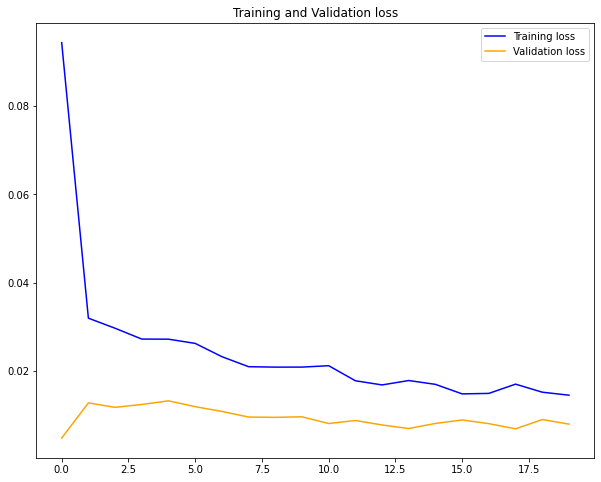

r2_score: -0.5515443517346088


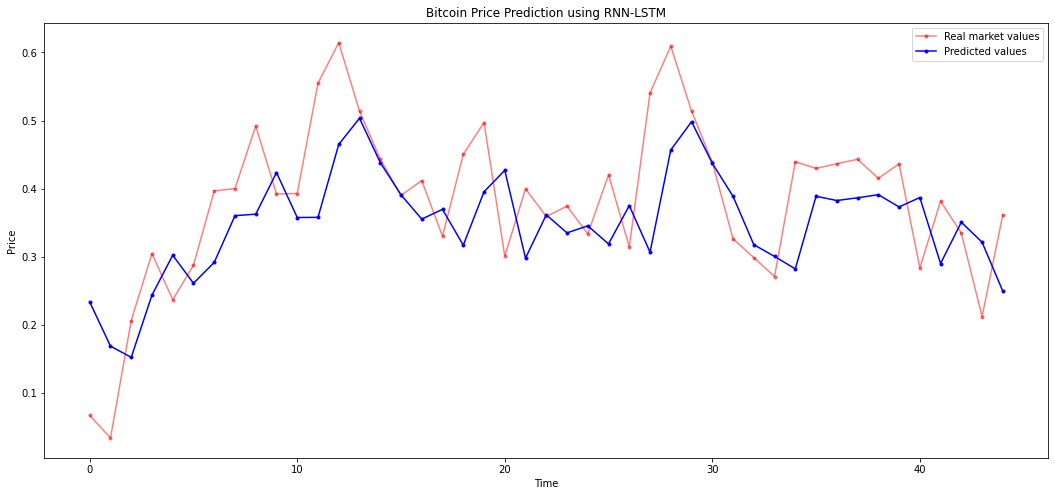

In [26]:
# Plotting data 

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 8))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title("Training and Validation loss")
plt.legend()
plt.show()

# Predict the model
y_pred = model.predict(x_test)
print("r2_score:", r2_score(y_pred, y_test))

plt.figure(figsize=(18,8))
plt.plot(y_test, '.-', color='red', label='Real market values', alpha=0.5)
plt.plot(y_pred, '.-', color='blue', label='Predicted values', alpha=1)
plt.title("Bitcoin Price Prediction using RNN-LSTM")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()